# Applied Machine Learning: Homework Exercise 04-1

## Goal

Apply what you have learned about using pipelines for efficient pre-processing and model training on a regression problem.

## House Prices in King County

In this exercise, we want to model house sale prices in King County in the state of Washington, USA.

We use a dataset containing information about residential home sales, which includes various features such as the date of sale, number of bedrooms and bathrooms, living space area, and location data like the zipcode.

We begin with some basic feature preprocessing as in the previous exercise.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

rng = np.random.default_rng(124)

X, y = fetch_openml(data_id=42092, as_frame=True, return_X_y=True)
# To be consistent with mlr3data package, we need the following steps [1-4].
# 1. Convert dates from strings to datetime
X['date'] = pd.to_datetime(X['date'])

# 2. Replace 0 values with NA in yr_renovated
X['yr_renovated'] = X['yr_renovated'].replace(0, np.nan)

# 3. Replace 0 values with NA in sqft_basement
X['sqft_basement'] = X['sqft_basement'].replace(0, np.nan)

# 4. Convert waterfront to category
X['waterfront'] = X['waterfront'].astype('category')

# Convert zipcode to category
X['zipcode'] = X['zipcode'].astype('category')

# Transform date to numeric variable (days since earliest date)
min_date = X['date'].min()
X['date'] = (X['date'] - min_date).dt.days

# Scale the target variable by dividing by 1000
y = y.astype(float) / 1000

# Check for columns with NaN values
cols_with_nan = X.columns[X.isna().any()].tolist()
print(f"Columns with NaN values: {cols_with_nan}")

# Make a copy of X, we will drop some columns. In the later part, we will add back the columns with missing values.
X_with_missing = X.copy()

# Delete columns containing NAs
X = X.drop(cols_with_nan, axis=1)

# Print information about the DataFrame
print("DataFrame info:")
print(X.info())

Columns with NaN values: ['sqft_basement', 'yr_renovated']
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           21613 non-null  int64   
 1   bedrooms       21613 non-null  int64   
 2   bathrooms      21613 non-null  float64 
 3   sqft_living    21613 non-null  int64   
 4   sqft_lot       21613 non-null  int64   
 5   floors         21613 non-null  float64 
 6   waterfront     21613 non-null  category
 7   view           21613 non-null  int64   
 8   condition      21613 non-null  int64   
 9   grade          21613 non-null  int64   
 10  sqft_above     21613 non-null  int64   
 11  yr_built       21613 non-null  int64   
 12  zipcode        21613 non-null  category
 13  lat            21613 non-null  float64 
 14  long           21613 non-null  float64 
 15  sqft_living15  21613 non-null  int64   
 16  s

## Add uncorrelated features to data

To test different strategies for feature selection in this exercise, we create two artificial features that are mostly uncorrelated with the target variable `price`:

- `x1` is a uniformly distributed random variable.
- `x2` is defined as the sine of a product involving `price` and the `grade` feature.

In [2]:
# x1: uniformly distributed random numbers (mostly uncorrelated with price)
X['x1'] = rng.uniform(0, 1, size=len(X))
corr_x1 = X['x1'].corr(y)
print(f"Correlation between x1 and price: {corr_x1:.8f}")

# x2: sine transformation based on price and grade
X['x2'] = np.sin(0.01 * y * X['grade'])
corr_x2 = X['x2'].corr(y)
print(f"Correlation between x2 and price: {corr_x2:.8f}")

Correlation between x1 and price: 0.00179391
Correlation between x2 and price: 0.01329962


## Train-test split

Before we train a model, let's remove some data for evaluating our model later on:

In [3]:
from sklearn.model_selection import train_test_split


# We reserve 60% for training and 40% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=124)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 12967, Test set size: 8646


## Conditional Encoding

In the King county data, there are two categorial features encoded as factor: `waterfront` (with 2 unique values) and `zipcode` (with 70 unique values).

Obviously, `waterfront` is a low-cardinality feature suitable for one-hot encoding and `zipcode` is a very high-cardinality feature. Therefore, it would make sense to create a pipeline that first pre-processes each factor variable with either impact or one-hot encoding, depending on the feature cardinality.

As in the previous exercise, we will use `sklearn.preprocessing.TargetEncoder` to encode the categorical features.

In [4]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

Now utlize these defined functions and variables above to determine which features will be encoded and what encoders will be applied.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder


# Separate features based on cardinality
onehot_features = []
target_features = []

for feature in categorical_features:
    # Count unique values (cardinality)
    cardinality = X_train[feature].nunique()
    
    # If cardinality > 10, use target encoder, otherwise use onehot encoder
    if cardinality > 10:
        target_features.append(feature)
    else:
        onehot_features.append(feature)

print(f"Features to be one-hot encoded: {onehot_features}")
print(f"Features to be target encoded: {target_features}")

# Set up a ColumnTransformer with the specified encoders
transformers = []
if onehot_features:
    transformers.append(('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_features))
if target_features:
    transformers.append(('target', TargetEncoder(smooth=0.0001), target_features))

cat_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough')

Features to be one-hot encoded: ['waterfront']
Features to be target encoded: ['zipcode']


## Filters

Filter algorithm select features by assigning numeric scores to each features, e.g. correlation between features and the target variable, use these to rank the features and select a feature subset based on the ranking. Features that are assigned lower scores are then omitted in subsequent modeling steps. Check out the details in [`sklearn.feature_selection`](https://scikit-learn.org/stable/api/sklearn.feature_selection.html#module-sklearn.feature_selection).

## Exercises

## Exercise 1: Create a complex pipeline

Create a pipeline with the following sequence of elements:

1. Each categorical feature should be preprocessed with either one-hot encoding or target-based encoding, depending on the number of unique values (cardinality). For example, use one-hot encoding for low-cardinality features and a suitable alternative for high-cardinality ones.

2. Apply a feature selection step that uses the Pearson correlation coefficient to rank all features and selects the 3 most correlated with the target variable.

3. Train a random forest regressor.

Wrap this pipeline into a hyperparameter tuning procedure using randomized search, two-fold cross-validation, and mean squared error as the performance metric. Train the model on the training set, and evaluate its performance on the holdout test set.

<details><summary>Hint 1:</summary>
Use `SelectKBest` with a custom scoring function to compute absolute Pearson correlations between features and the target.
</details>

<details><summary>Hint 2:</summary>
Use `RandomizedSearchCV` to perform hyperparameter tuning. Make sure to define the parameter distribution for your random forest as follows:

```python
param_distributions = {
    'regressor__max_features': uniform(0.1, 0.9),
    'regressor__n_estimators': randint(1, 2000),
}

```
</details>



In [6]:
#===SOLUTION===

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline


# Define a custom scoring function for feature selection
def correlation_score(X, y):
    correlations = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
         # Avoid division by zero
        if np.std(X[:, i]) > 0:
            correlations[i] = abs(np.corrcoef(X[:, i], y)[0, 1])
    return correlations

# Build the pipeline
pipeline = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('feature_selector', SelectKBest(score_func=correlation_score, k=3)),
    ('regressor', RandomForestRegressor(max_depth=10, random_state=124))
])


# Define parameter distributions
param_distributions = {
    'regressor__max_features': uniform(0.1, 0.9),
    'regressor__n_estimators': randint(1, 2000),
}

cv_corr = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=124,
    verbose=1,
    n_jobs=-1
)

cv_corr.fit(X_train, y_train)

predictions = cv_corr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Best parameters: {cv_corr.best_params_}')
print(f"Test MSE: {mse:.2f}")

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters: {'regressor__max_features': 0.32929502313278897, 'regressor__n_estimators': 278}
Test MSE: 27007.79


## Exercise 2: Information gain

An alternative filter method is information gain. Recreate the pipeline from exercise 1, but use information gain as filter. Again, select the three features with the highest information gain. Train the `RandomizedSearchCV` on the training data, and evaluate the performance on the holdout test data.

You can make the score function based on `sklearn.feature_selection.information_gain_score`. 

Important: We need to construct a Boolean mask vector, `is_discrete`, to flag which features are discrete. Later, we’ll pass this vector to the `mutual_info_regression` function. Note that using the `cat_transformer` (with `OneHotEncoder`) will expand the number of columns, so we must inspect the transformed feature names to determine which columns correspond to discrete features. Any transformed feature that originates from `categorical_features`—or from one of the following: `['view', 'grade', 'date', 'yr_built', 'condition', 'bedrooms']`—should be marked as discrete.

In [7]:
# We create a temporary ColumnTransformer to transform the data and get the transformed feature names
tmp_cat_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough')
X_train_transformed = tmp_cat_transformer.fit_transform(X_train, y_train)
# Get the transformed feature names
transformed_features = tmp_cat_transformer.get_feature_names_out()
print("Transformed feature names:")
print(transformed_features)

# Check the shape of the transformed data
print(f"\nTransformed data shape: {X_train_transformed.shape}")

# Create a boolean vector indicating which features are discrete
is_discrete = np.array([
    'waterfront' in feature or 
    'zipcode' in feature or
    any(discrete_feat in feature for discrete_feat in ['view', 'grade', 'date', 'yr_built', 'condition', 'bedrooms'])
    for feature in transformed_features
])

print("\nDiscrete features mask:")
print(is_discrete)

Transformed feature names:
['onehot__waterfront_0' 'onehot__waterfront_1' 'target__zipcode'
 'remainder__date' 'remainder__bedrooms' 'remainder__bathrooms'
 'remainder__sqft_living' 'remainder__sqft_lot' 'remainder__floors'
 'remainder__view' 'remainder__condition' 'remainder__grade'
 'remainder__sqft_above' 'remainder__yr_built' 'remainder__lat'
 'remainder__long' 'remainder__sqft_living15' 'remainder__sqft_lot15'
 'remainder__x1' 'remainder__x2']

Transformed data shape: (12967, 20)

Discrete features mask:
[ True  True  True  True  True False False False False  True  True  True
 False  True False False False False False False]


In [8]:
#===SOLUTION===

from sklearn.feature_selection import mutual_info_regression


# Define a custom scoring function using mutual information (information gain)
def information_gain_score(X, y):
    scores = mutual_info_regression(X, y, discrete_features=is_discrete, random_state=124)
    return scores

# Build the pipeline with information gain feature selection
pipeline_info = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('feature_selector', SelectKBest(score_func=information_gain_score, k=3)),
    ('regressor', RandomForestRegressor(max_depth=10, random_state=124))
])

cv_info = RandomizedSearchCV(
    pipeline_info,
    param_distributions=param_distributions,
    n_iter=20,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=111,
    verbose=1,
    n_jobs=-1
)

cv_info.fit(X_train, y_train)
predictions_info = cv_info.predict(X_test)
mse_info = mean_squared_error(y_test, predictions_info)
print(f"Test MSE with Information Gain Filter: {mse_info:.2f}")


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Test MSE with Information Gain Filter: 29660.62


## Exercise 3: Pearson correlation vs. Information gain

By comparing the test MSEs of the two filter methods, we can see that the Pearson correlation filter appears to select features that lead to better model performance. To understand why this might be the case, inspect the trained models and determine which features were selected.

Check which features were chosen by the correlation-based filter versus an alternative filter method like information gain. Then, reason about how the characteristics of these methods influence their feature selections and how that, in turn, affects the model's performance.

For example, consider whether the artificially created feature x2—which was designed to be largely uncorrelated with the target—was selected by either method. 
<details><summary>Hint 1:</summary> 
Use `.get_support(indices=True)` from `SelectKBest` to retrieve the indices of the selected features, and map them back to their corresponding column names. 
</details> 

In [9]:
#===SOLUTION===

# Get indices of selected features
correlation_features = cv_corr.best_estimator_.named_steps['feature_selector'].get_support(indices=True)
info_gain_features = cv_info.best_estimator_.named_steps['feature_selector'].get_support(indices=True)

print(transformed_features[correlation_features])
print(transformed_features[info_gain_features])

['target__zipcode' 'remainder__sqft_living' 'remainder__grade']
['target__zipcode' 'remainder__sqft_living' 'remainder__x2']


Question: Discuss the results.

===SOLUTION===

The correlation filter does not select `x2`, a feature that we artificially created and is uncorrelated with the outcome price. However, the information gain filter selects for `x2`. This can be seen from how it was computed in the first place: `X['x2'] = np.sin(0.01 * y * X['grade'])`. Indeed, it is a sin-transformed function of the `y` and `grade`, something that is not necessarily obvious from a simple visual inspection.

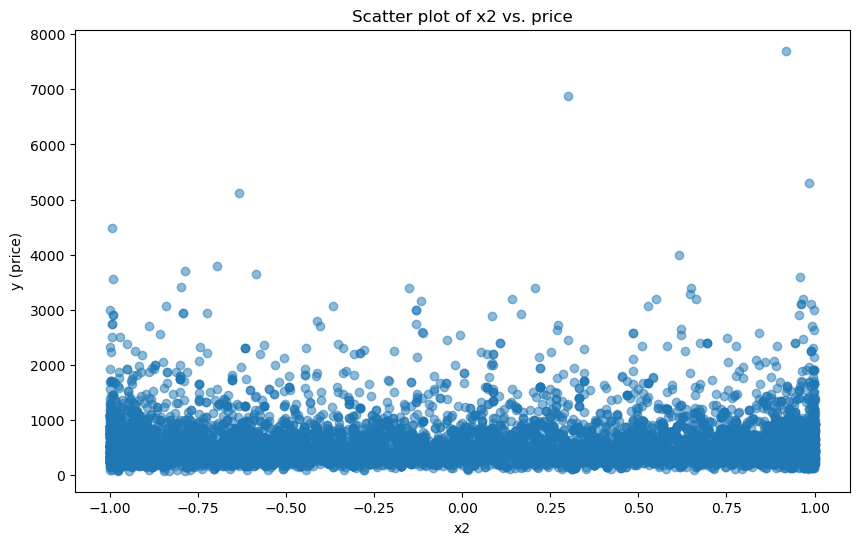

In [10]:
#===SOLUTION===

import matplotlib.pyplot as plt

# Create a scatter plot of x2 vs. price
plt.figure(figsize=(10, 6))
plt.scatter(X_train['x2'], y_train, alpha=0.5)
plt.xlabel('x2')
plt.ylabel('y (price)')
plt.title('Scatter plot of x2 vs. price')
plt.show()


## Summary

We learned about more complex pipelines, including pre-processing methods for variable encoding and feature filtering.